In [1]:
import json 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('Cell_Phones_and_Accessories_5.json', 'r') as file:
    data = [json.loads(line) for line in file]

norm_data = pd.json_normalize(data)
df = pd.DataFrame(norm_data)
df.head()

reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...      4.0   
1  These stickers work like the review says they ...      5.0   
2  These are awesome and make my phone look so st...      5.0   
3  Item arrived in great time and was in perfect ...      4.0   
4  awesome! stays on, and looks great. can be use...      5.0   

                                     summary  unixReviewTime   reviewTime  
0                                 Looks Good      1400630400  05 21, 2014  
1                      Really great product.      1389657600  01 14, 2014  
2                             LOVE LOVE LOVE      1403740800  06 26, 2014  
3                                      Cute!      1382313600  10 21, 2013  
4  leopard home button sticker for iphone 4s      1359849600   02 3, 2013

In [3]:
print(f"{df.shape[0]} reviews")
print(f"{df["asin"].nunique()} unique products")
print(f"{df['reviewerID'].nunique()} unique reviewers")

194439 reviews
10429 unique products
27879 unique reviewers


In [4]:
print(f"Minimum reviews for a single product: {df["asin"].value_counts()[-1]}")
print(f"Minimum reviews from a single user: {df["reviewerID"].value_counts()[-1]}")

Minimum reviews for a single product: 5
Minimum reviews from a single user: 5


C:\Users\darth\AppData\Local\Temp\ipykernel_22944\4191937166.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Minimum reviews for a single product: {df["asin"].value_counts()[-1]}")
C:\Users\darth\AppData\Local\Temp\ipykernel_22944\4191937166.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Minimum reviews from a single user: {df["reviewerID"].value_counts()[-1]}")


We can see here that the dataset has only considered reviewers with a minimum of 5 reviews written, and products with a minimum of 5 reviews recieved. The below cell shows all the reviews submitted by user "A4N8QJCW9EY1A"

In [5]:
print(df.loc[df["reviewerID"] == "A4N8QJCW9EY1A"] ["reviewText"])

186013    I don't use apple products, so when someone wi...
190481    Adoption of the USB standard for chargers has ...
193880    I use my laptop or desktop to charge most devi...
194066    My truck already has three 12 volt sockets (on...
194099    After using this for about a week, I can't thi...
Name: reviewText, dtype: object


My next goal will be to get 100 reviews of a specific product and identify key aspects that are commonly mentioned in reviews. I will use product "B005SUHPO6" since it is the most reviewed in the dataset. 

In [6]:
df_filtered = df[df["asin"] == "B005SUHPO6"][:100].reset_index()
df_filtered_reviews = df_filtered["reviewText"]
df_filtered_reviews
for i in range(10):
    print(df_filtered_reviews[i])

excellent product at 1/2 the price as sale at electronic store, wow fit perfect on my iphone
Sometimes the flap over the charging place is hard to stay locked in, I have to keep trying and trying to lock it in there, it drives me crazy!!!!  I love the  colors that I bought, the blue one I have not used yet, maybe next year.  I like a change once in awhile......other than the locking in flap, I am happy with them.
Great case.  Fits like every other Otterbox Defender case I have own.  It does a great job of protecting your phone from drops onto the ground.  I feel that the Defender case is a bit bulky sometimes, but the holster is a major plus for my dad.
Use these for our technicians and anyone that is hard on a phone.  In a business environment you need a touch case to avoid costly repairs.
It's very strong and protects my 4S phone! I think this was a great value! I will buy another one in a newer color!
you know what. It has three layers, and for what? It does protect your phone again

Looking at this paragraph these ten topics seem to be frequently mentioned: ["price", "drop protection", "fit", "aesthetics", "durability", "weight", "ease of use", "quality", "dust protection", "slimness"]. Time to run the zero-shot classification to find the main topic of each review.

In [7]:
aspects = ["price", "protection", "fit", "aesthetics", "durability", "weight", "ease of use", "quality", "repurchase intent", "bulkyness"]
review_list = df_filtered_reviews.tolist()

from transformers import pipeline

pipe = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
score_table = pipe(review_list,
    candidate_labels=aspects,
    multi_label=True
)

c:\Users\darth\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


In [8]:
score_table = pd.DataFrame(score_table)
score_table = score_table.explode(["labels", "scores"])
score_table = score_table.pivot_table(index="sequence",
                                 columns="labels",
                                 values="scores",
                                 aggfunc="mean")
score_table

labels                                             aesthetics bulkyness  \
sequence                                                                  
A great phone case wow I dropped my phone so ma...   0.009285  0.065796   
A must have to protect your iphone.  I will say...   0.000639  0.961681   
After two years, I needed to replace my Otterbo...   0.111634  0.277408   
Bulky and annoying but does what it's supposed ...   0.007374  0.993055   
Did a nice job. Makes my son's I-phone secure, ...   0.928329  0.002078   
...                                                       ...       ...   
purchased as a gift loved it and a great buy to...   0.001163  0.002481   
this case offers great protection for your ipho...   0.001854  0.894602   
this is a great case, fits the phone nicely, an...   0.562407  0.265927   
very good protection but is quite bulky  recomm...   0.001621  0.980874   
you know what. It has three layers, and for wha...   0.043534  0.871273   

labels                                             durability ease of use  \
sequence                                                                    
A great phone case wow I dropped my phone so ma...   0.962288    0.350595   
A must have to protect your iphone.  I will say...   0.573857    0.002765   
After two years, I needed to replace my Otterbo...   0.965296    0.411888   
Bulky and annoying but does what it's supposed ...   0.692297    0.004467   
Did a nice job. Makes my son's I-phone secure, ...   0.837292    0.891422   
...                                                       ...         ...   
purchased as a gift loved it and a great buy to...   0.825439    0.587903   
this case offers great protection for your ipho...   0.704803    0.003802   
this is a great case, fits the phone nicely, an...   0.913793    0.937386   
very good protection but is quite bulky  recomm...   0.820835    0.000454   
you know what. It has three layers, and for wha...   0.431776    0.180297   

labels                                                   fit     price  \
sequence                                                                 
A great phone case wow I dropped my phone so ma...  0.908043   0.24034   
A must have to protect your iphone.  I will say...  0.822356  0.109718   
After two years, I needed to replace my Otterbo...    0.8817  0.384208   
Bulky and annoying but does what it's supposed ...  0.395219  0.232568   
Did a nice job. Makes my son's I-phone secure, ...  0.991482  0.122335   
...                                                      ...       ...   
purchased as a gift loved it and a great buy to...  0.989355  0.836659   
this case offers great protection for your ipho...  0.894257  0.650736   
this is a great case, fits the phone nicely, an...   0.99797  0.955626   
very good protection but is quite bulky  recomm...  0.711978  0.056476   
you know what. It has three layers, and for wha...  0.906185  0.315599   

labels                                             protection   quality  \
sequence                                                                  
A great phone case wow I dropped my phone so ma...   0.930523  0.988705   
A must have to protect your iphone.  I will say...   0.985115  0.939447   
After two years, I needed to replace my Otterbo...   0.975193  0.985828   
Bulky and annoying but does what it's supposed ...   0.985395  0.332564   
Did a nice job. Makes my son's I-phone secure, ...   0.962089  0.997653   
...                                                       ...       ...   
purchased as a gift loved it and a great buy to...   0.992389  0.997733   
this case offers great protection for your ipho...   0.959885  0.969876   
this is a great case, fits the phone nicely, an...   0.996008  0.999126   
very good protection but is quite bulky  recomm...   0.971678  0.977169   
you know what. It has three layers, and for wha...   0.916381  0.615086   

labels                                             repurchase intent    weight  
se

In [9]:
for col in score_table.columns:
    score_table[col] = pd.to_numeric(score_table[col], errors="coerce")
score_table["main topic"] = score_table.idxmax(axis=1, numeric_only=True)


Now we have a table with scores for each topic, for each review. We have also noted down with topic scored highest for each review, lets see how often each topic "won", and what the distribution of the scores were for the main topics.

In [10]:
score_table = score_table.reset_index()

In [11]:
topics_df=pd.DataFrame(score_table.columns.drop("main topic"))
topics_df.rename(columns={"labels" : "main topic"}, inplace=True)
freq_df = pd.DataFrame(score_table["main topic"].value_counts()).reset_index()
freq_df = topics_df.merge(freq_df, on="main topic", how="left")
freq_df["count"] = freq_df["count"].fillna(0).astype(int)

C:\Users\darth\AppData\Local\Temp\ipykernel_22944\4109146960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(data = freq_df,
C:\Users\darth\AppData\Local\Temp\ipykernel_22944\4109146960.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bp.set_xticklabels(labels = freq_df["main topic"],


[Text(0.5, 0, 'Topic'), Text(0, 0.5, 'Frequency as the Main Topic')]

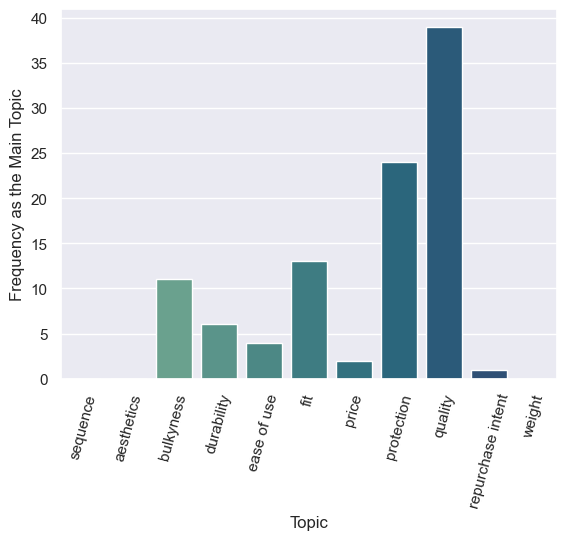

In [12]:
# Produce a bar chart to show frequency of each topic as the main topic
sns.set_theme()
bp = sns.barplot(data = freq_df,
            x="main topic",
            y="count",
            palette="crest",
            )
bp.set_xticklabels(labels = freq_df["main topic"],
                   rotation = 75)
bp.set(xlabel="Topic", ylabel="Frequency as the Main Topic")

C:\Users\darth\AppData\Local\Temp\ipykernel_22944\2948153635.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  kde = sns.kdeplot(data=main_topic_scores, palette="crest")


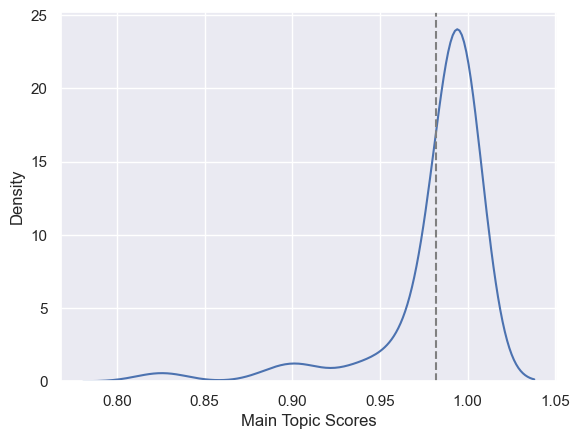

Average main topic score: 0.98


In [13]:
#Create main topic score column
column_indexer = score_table.columns.get_indexer(score_table["main topic"])
column_indexer
main_topic_scores = score_table.values[np.arange(len(score_table)), column_indexer]
main_topic_scores
kde = sns.kdeplot(data=main_topic_scores, palette="crest")
kde.set(xlabel="Main Topic Scores")
plt.axvline(x=np.mean(main_topic_scores), color='grey', linestyle='--')
plt.show()
print(f"Average main topic score: {round(np.mean(main_topic_scores), ndigits=2)}")

We see that aesthetics and weight are not chosen as the main aspect once, suggesting these are not good labels and we should change them. The average score for a main topic is 0.98, suggesting the zero-shot classifier is confident in its predictions. Now it's time to start implementing some sentiment analysis.

In [14]:
import torch
print(torch.__version__)

2.8.0+cu126


In [15]:
review_list = score_table["sequence"].tolist()
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
sentiment = sentiment_analysis(review_list)


Device set to use cuda:0


In [16]:
sentiment_df = pd.DataFrame(sentiment).rename(columns={"label":"aspect sentiment", "score":"sentiment score"})
score_table = score_table.reset_index().join(sentiment_df)

In [17]:
score_table.loc[score_table["aspect sentiment"] == "NEGATIVE"]

index                                           sequence  aesthetics  \
8       8  Flap at top left ripped.  Unsightly.  Have own...    0.440430   
21     21  I bought a couple of these for my wife and dau...    0.015827   
34     34  I love the protection for my new Apple 4s but ...    0.009022   
37     37  I purchased this otterbox case because of all ...    0.381128   
38     38  I purchased this same case in black 2 years ag...    0.328761   
41     41  I would not recommend this product, it is bulk...    0.202211   
44     44  It almost feels wrong to put this bulky, clunk...    0.059781   
51     51  My daughter had this on her new phone and afte...    0.084214   
63     63  So disappointed with Otterbox these days. Poor...    0.145443   
70     70  This case does not hold up. It has torn, broke...    0.025237   
99     99  you know what. It has three layers, and for wh...    0.043534   

    bulkyness  durability  ease of use       fit     price  protection  \
8    0.635729    0.099793     0.007921  0.008432  0.819477    0.611184   
21   0.991967    0.807099     0.011116  0.403428  0.401723    0.966188   
34   0.997370    0.645591     0.005636  0.245104  0.346955    0.995539   
37   0.900145    0.654919     0.682364  0.787489  0.557225    0.865991   
38   0.533834    0.775361     0.299631  0.469370  0.494721    0.885515   
41   0.990663    0.964509     0.547688  0.811532  0.944307    0.972901   
44   0.985959    0.663306     0.042465  0.241144  0.080405    0.991787   
51   0.110983    0.831589     0.372945  0.043160  0.168629    0.702241   
63   0.996651    0.188951     0.147570  0.069283  0.920022    0.781490   
70   0.572640    0.824877     0.023446  0.018370  0.751440    0.897027   
99   0.871273    0.431776     0.180297  0.906185  0.315599    0.916381   

     quality  repurchase intent    weight  main topic aspect sentiment  \
8   0.002738           0.170447  0.378403       price         NEGATIVE   
21  0.652961           0.186310  0.369540   bulkyness         NEGATIVE   
34  0.993875           0.950475  0.985836   bulkyness         NEGATIVE   
37  0.098087           0.449087  0.423807   bulkyness         NEGATIVE   
38  0.062339           0.499506  0.399654  protection         NEGATIVE   
41  0.848208           0.505069  0.964101   bulkyness         NEGATIVE   
44  0.747164           0.041761  0.958291  protection         NEGATIVE   
51  0.269755           0.268479  0.088287  durability         NEGATIVE   
63  0.135125           0.168586  0.594049   bulkyness         NEGATIVE   
70  0.165623           0.263166  0.595025  protection         NEGATIVE   
99  0.615086           0.454104  0.570147  protection         NEGATIVE   

    sentiment score  
8          0.999497  
21         0.999503  
34         0.999500  
37         0.999510  
38         0.999507  
41         0.999504  
44         0.999474  
51         0.999501  
63         0.999504  
70         0.999508  
99         0.999511

So far I can only attribute one aspect to each review, I want to break the sentences down to be able to have more than one aspect for a single review.

In [18]:
from nltk.tokenize import PunktTokenizer

def tokenise_sentences(text):
    if pd.isnull(text):
        return None
    return PunktTokenizer().tokenize(text.strip())

tokenised_reviews = df_filtered_reviews.apply(tokenise_sentences)
tokenised_reviews = tokenised_reviews.explode()
new_review_list = tokenised_reviews.tolist()

In [19]:
new_score_table = pipe(new_review_list,
    candidate_labels=aspects,
    multi_label=True
)

In [20]:
new_score_table = pd.DataFrame(new_score_table)
new_score_table = new_score_table.explode(["labels","scores"])
new_score_table = new_score_table.pivot_table(index="sequence",
                            columns="labels",
                            values="scores",
                            aggfunc="mean")


In [21]:
for col in new_score_table.columns:
    new_score_table[col] = pd.to_numeric(new_score_table[col], errors="coerce")
new_score_table["main topic"] = new_score_table.idxmax(axis=1, numeric_only=True)

In [22]:
new_score_table = new_score_table.reset_index()

In [23]:
topics_df=pd.DataFrame(new_score_table.columns.drop("main topic"))
topics_df.rename(columns={"labels" : "main topic"}, inplace=True)
freq_df = pd.DataFrame(new_score_table["main topic"].value_counts()).reset_index()
freq_df = topics_df.merge(freq_df, on="main topic", how="left")
freq_df["count"] = freq_df["count"].fillna(0).astype(int)

C:\Users\darth\AppData\Local\Temp\ipykernel_22944\4109146960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(data = freq_df,
C:\Users\darth\AppData\Local\Temp\ipykernel_22944\4109146960.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bp.set_xticklabels(labels = freq_df["main topic"],


[Text(0.5, 0, 'Topic'), Text(0, 0.5, 'Frequency as the Main Topic')]

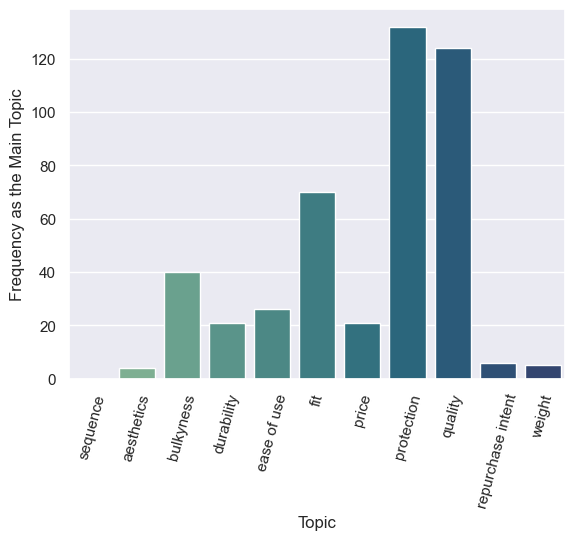

In [24]:
# Produce a bar chart to show frequency of each topic as the main topic
sns.set_theme()
bp = sns.barplot(data = freq_df,
            x="main topic",
            y="count",
            palette="crest",
            )
bp.set_xticklabels(labels = freq_df["main topic"],
                   rotation = 75)
bp.set(xlabel="Topic", ylabel="Frequency as the Main Topic")

C:\Users\darth\AppData\Local\Temp\ipykernel_22944\934831899.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  kde = sns.kdeplot(data=main_topic_scores, palette="crest")


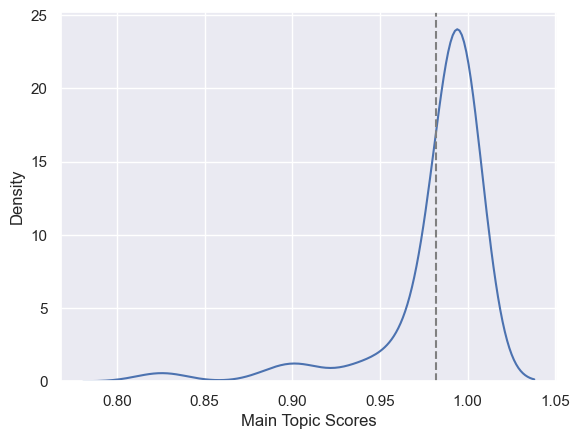

Average main topic score: 0.982


In [25]:
#Create main topic score column
column_indexer = score_table.columns.get_indexer(score_table["main topic"])
column_indexer
main_topic_scores = score_table.values[np.arange(len(score_table)), column_indexer]
main_topic_scores
kde = sns.kdeplot(data=main_topic_scores, palette="crest")
kde.set(xlabel="Main Topic Scores")
plt.axvline(x=np.mean(main_topic_scores), color='grey', linestyle='--')
plt.show()
print(f"Average main topic score: {round(np.mean(main_topic_scores), ndigits=3)}")

Now weight and aesthetics have some picks as the main topic, this new analysis has caught some opinions that were originally overlooked.

In [26]:
new_review_list = new_score_table["sequence"].tolist()
new_sentiment = sentiment_analysis(new_review_list)

In [27]:
sentiment_df = pd.DataFrame(new_sentiment).rename(columns={"label":"aspect sentiment", "score":"sentiment score"})
new_score_table = new_score_table.reset_index().join(sentiment_df)

In [28]:
new_score_table["sentiment score"] = np.where(new_score_table["aspect sentiment"] == "NEGATIVE", new_score_table["sentiment score"] * -1, new_score_table["sentiment score"])

In [29]:
new_score_table

index                                           sequence  aesthetics  \
0        0                                                  !    0.366696   
1        1                                             !!!!!!    0.189742   
2        2  ***UPDATE- I just filed a claim with Otterbox,...    0.107505   
3        3          2) The screen protector is crystal clear.    0.336984   
4        4  3) Survivor covers all ports for moisture/dust...    0.002756   
..     ...                                                ...         ...   
444    444  this is a great case, fits the phone nicely, a...    0.386433   
445    445  very good protection but is quite bulky  recom...    0.001621   
446    446                           when they're not in use.    0.128420   
447    447  you can literally through your phone against t...    0.051452   
448    448                                     you know what.    0.747840   

     bulkyness  durability  ease of use       fit     price  protection  \
0     0.068709    0.297096     0.515097  0.672367  0.162028    0.525509   
1     0.053639    0.070605     0.063232  0.009946  0.153248    0.300605   
2     0.147279    0.487028     0.398724  0.860529  0.529649    0.928244   
3     0.000308    0.459163     0.442097  0.976443  0.029175    0.990450   
4     0.085021    0.749040     0.028093  0.550268  0.127032    0.941421   
..         ...         ...          ...       ...       ...         ...   
444   0.000560    0.992464     0.959456  0.998481  0.244994    0.996741   
445   0.980874    0.820835     0.000454  0.711978  0.056476    0.971678   
446   0.093157    0.425964     0.320624  0.292983  0.233320    0.396545   
447   0.004243    0.637233     0.958746  0.969116  0.051441    0.633635   
448   0.098244    0.552466     0.849727  0.990375  0.412840    0.658152   

      quality  repurchase intent    weight  main topic aspect sentiment  \
0    0.876604           0.233874  0.088456     quality         POSITIVE   
1    0.499449           0.177081  0.057874     quality         POSITIVE   
2    0.910046           0.430095  0.318881  protection         POSITIVE   
3    0.997393           0.040342  0.009071     quality         POSITIVE   
4    0.818267           0.014068  0.182223  protection         NEGATIVE   
..        ...                ...       ...         ...              ...   
444  0.999301           0.018085  0.331076     quality         POSITIVE   
445  0.977169           0.076033  0.972135   bulkyness         POSITIVE   
446  0.549151           0.129669  0.114769     quality         NEGATIVE   
447  0.812707           0.083214  0.018648         fit         POSITIVE   
448  0.882887           0.363650  0.170847         fit         NEGATIVE   

     sentiment score  
0           0.994315  
1           0.997844  
2           0.993989  
3           0.998749  
4          -0.989723  
..               ...  
444         0.998931  
445         0.998517  
446        -0.999032  
447         0.986262  
448        -0.986773  

[449 rows x 15 columns]

In [30]:
aspect_summary = new_score_table.drop(columns=["index", "sequence"])
aspect_summary = aspect_summary.groupby("main topic").agg(
    aspect_count = ("main topic", "size"),
    positive_count=("aspect sentiment", lambda x: (x == "POSITIVE").sum()),
    negative_count=("aspect sentiment", lambda x: (x == "NEGATIVE").sum()),
    average_sentiment_score=("sentiment score", "mean")
).reset_index()

In [31]:
aspect_summary.rename(columns={"main topic":"aspect"}, inplace=True)

In [38]:
aspect_summary.sort_values(by='average_sentiment_score', ascending=False, inplace=True)
aspect_summary

aspect  aspect_count  positive_count  negative_count  \
7            quality           124             113              11   
4                fit            70              63               7   
2         durability            21              16               5   
3        ease of use            26              19               7   
6         protection           132              73              59   
0         aesthetics             4               2               2   
8  repurchase intent             6               2               4   
1          bulkyness            40               8              32   
9             weight             5               1               4   
5              price            21               4              17   

   average_sentiment_score  
7                 0.821282  
4                 0.799256  
2                 0.522827  
3                 0.457086  
6                 0.107349  
0                -0.005455  
8                -0.331813  
1                -0.598265  
9                -0.599661  
5                -0.618587

Great, this table is what I was after! You can see this product is celebrated for its quality and fit, but is criticised for its weight, bulkiness and price. I want to turn this into a set of graphics to inform the user.

C:\Users\darth\AppData\Local\Temp\ipykernel_22944\2056975474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="average_sentiment_score", y="aspect", data=aspect_summary, palette=colour_list)


(-1.0, 1.0)

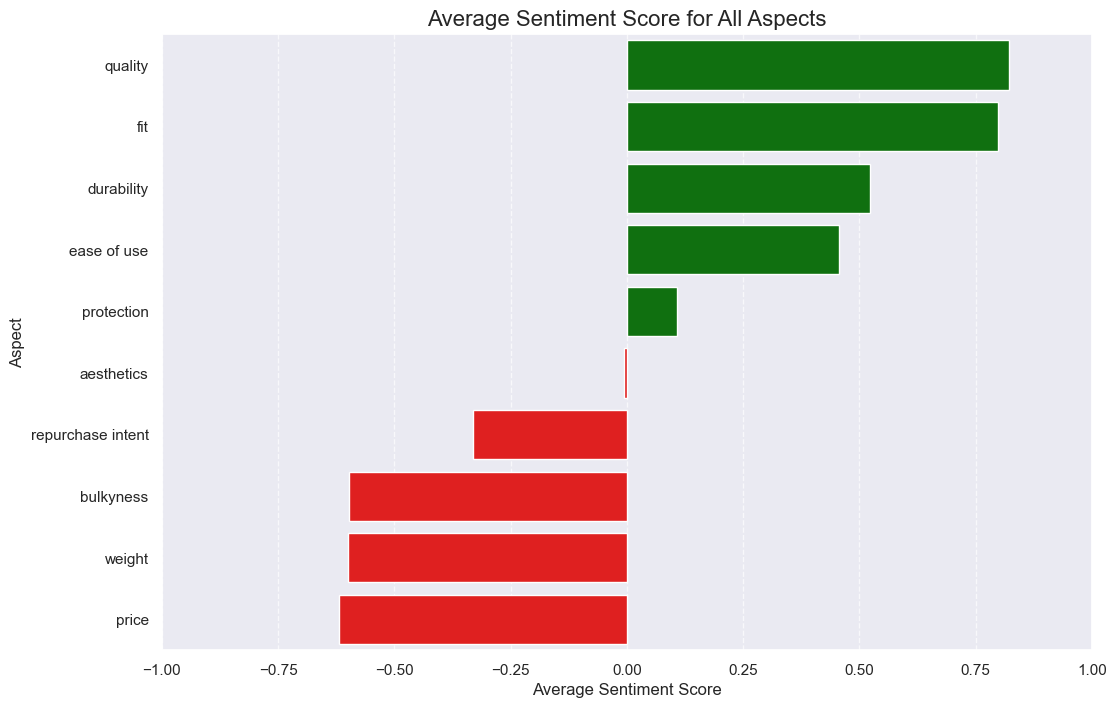

In [40]:
colour_list = []
for i in aspect_summary["average_sentiment_score"]:
    if i >= 0:
        colour_list.append("green")
    else:
        colour_list.append("red")

plt.figure(figsize=(12, 8))
sns.barplot(x="average_sentiment_score", y="aspect", data=aspect_summary, palette=colour_list)
plt.title("Average Sentiment Score for All Aspects", fontsize=16)
plt.xlabel("Average Sentiment Score")
plt.ylabel("Aspect")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.xlim(-1, 1)